In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np

import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2, 8, 11, 35, 26, 6, 4, 8, 3, 39, 49]
[27, 38, 12, 16, 13, 42, 5, 38, 29, 2,

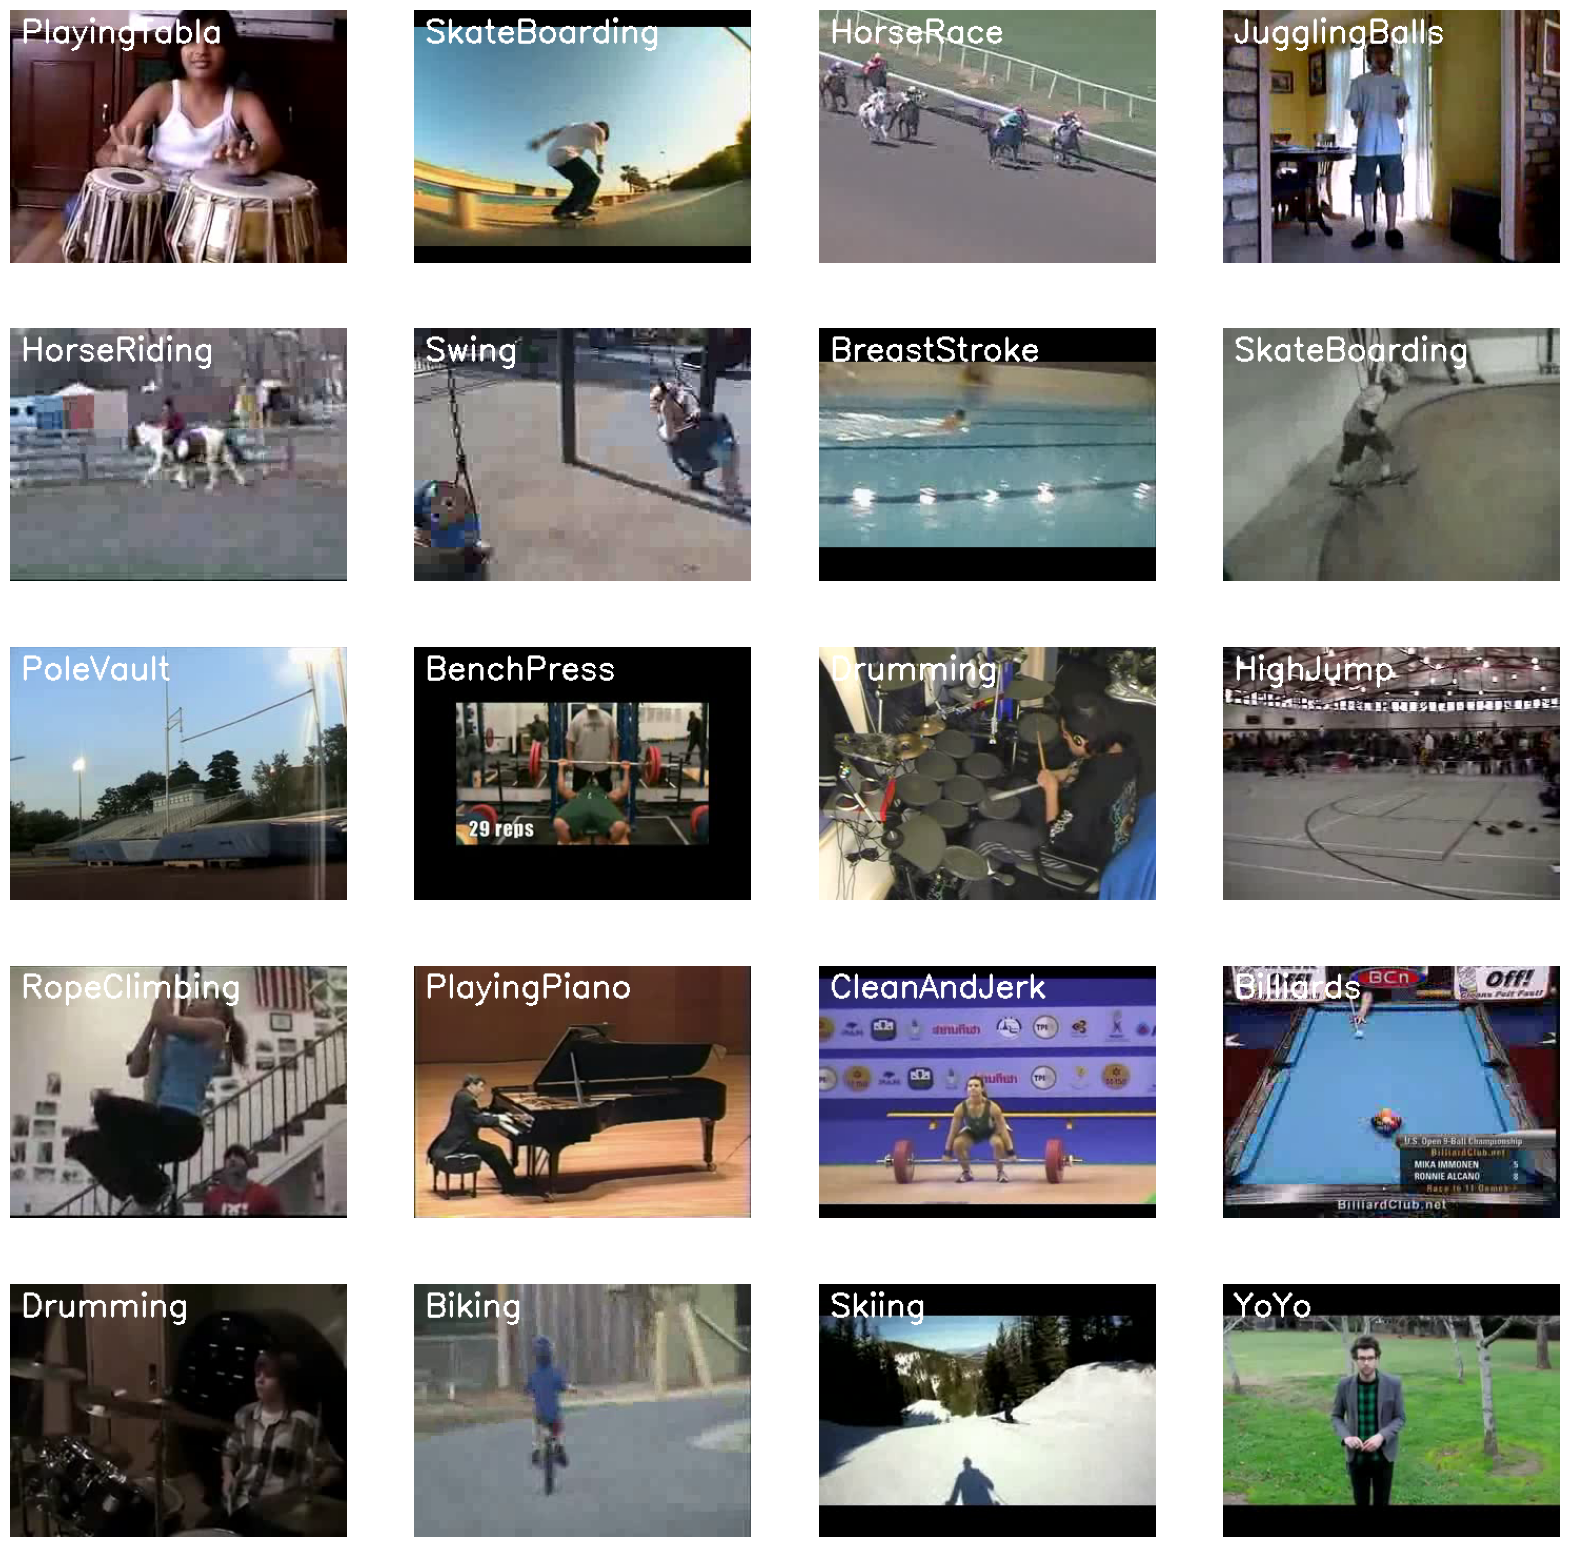

In [6]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir("data/l8/dataset/UCF50/")

random_range = random.sample(range(len(all_classes_names)), 20)
random_range = [random.randint(0, len(all_classes_names)) for _ in range(20)]

for counter, random_index in enumerate(random_range, 1):
    
    print(random_range)
    selected_class_name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f"data/l8/dataset/UCF50/{selected_class_name}")
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f"data/l8/dataset/UCF50/{selected_class_name}/{selected_video_file_name}")
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = "data/l8/dataset/UCF50/"
CLASSES_LIST = ["BenchPress", "PlayingGuitar", "PullUps", "PushUps"]

In [30]:
def frames_extraction(video_path):
    frames_list = []
    video_reader  = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [37]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f"Extracting Data of Class: {class_name}")
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)                                           
    features = np.asarray(features)
    labels = np.asarray(labels)
    video_files_paths = np.asarray(video_files_paths)
    return features, labels, video_files_paths

In [38]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BenchPress
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PullUps
Extracting Data of Class: PushUps


In [39]:
one_hot_encoded_labels = to_categorical(labels)

In [40]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle =True)

In [47]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                    IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.summary()
    return model

In [48]:
convlstm_model = create_convlstm_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 30, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 30, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 30, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 30, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 30, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 30, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 30, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 30, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        17,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,284 (196.42 KB)

 Trainable params: 50,284 (196.42 KB)

 Non-trainable params: 0 (0.00 B)

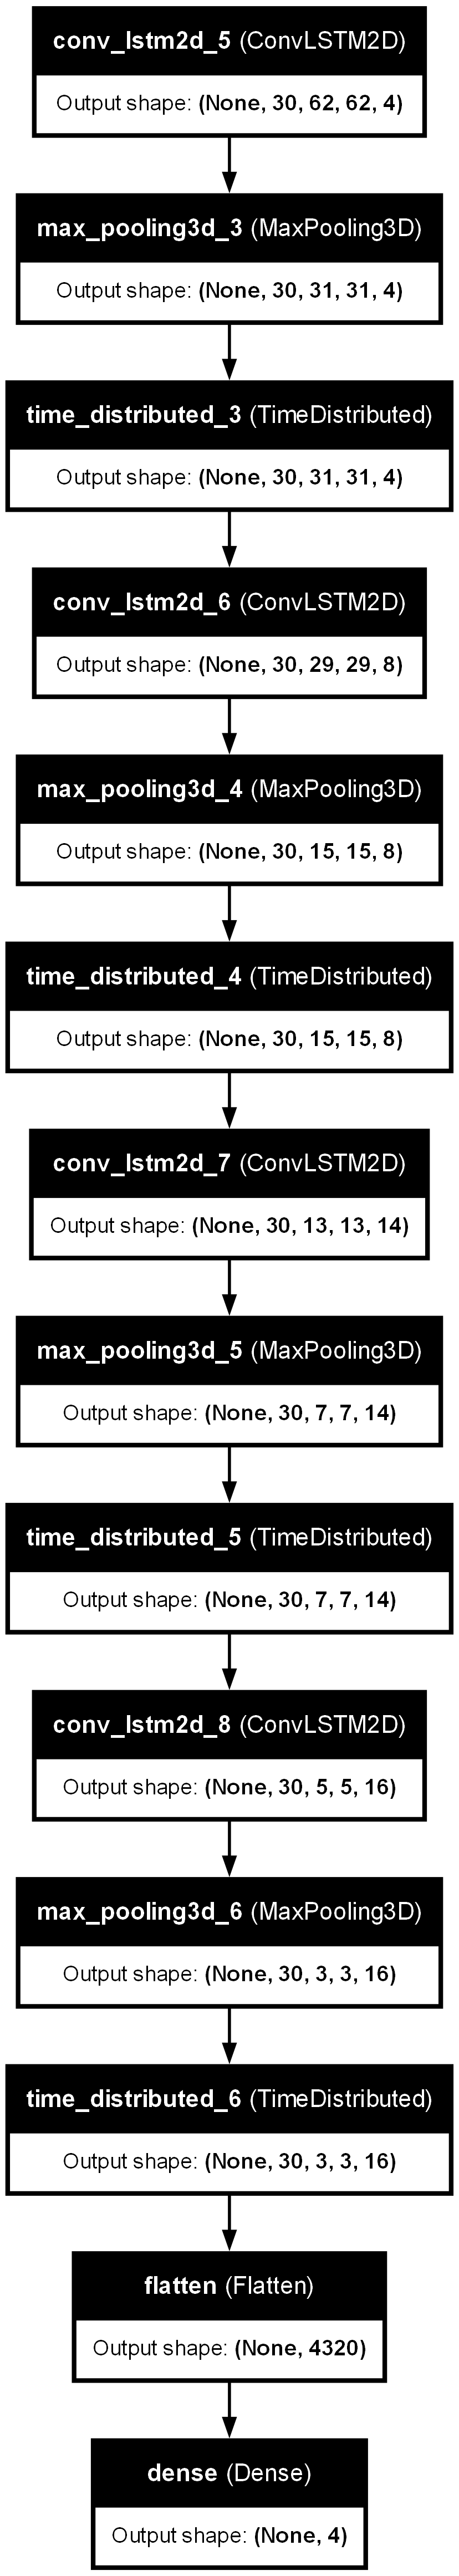

In [49]:
plot_model(convlstm_model, to_file='convlstm_model.png', show_shapes=True, show_layer_names=True)

In [51]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='mln', restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=10, batch_size=4,
                                                     shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])


Epoch 1/10


82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 304ms/step - accuracy: 0.7444 - loss: 0.6221 - val_accuracy: 0.8171 - val_loss: 0.4250
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.9157 - loss: 0.2356 - val_accuracy: 0.8415 - val_loss: 0.4286
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step - accuracy: 0.9282 - loss: 0.2454 - val_accuracy: 0.8780 - val_loss: 0.3256
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step - accuracy: 0.9965 - loss: 0.0541 - val_accuracy: 0.8780 - val_loss: 0.3041
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.9708 - loss: 0.1161 - val_accuracy: 0.6829 - val_loss: 1.0133
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step - accuracy: 0.7915 - loss: 0.5119 - val_accuracy: 0.9268 - val_loss: 0.2263
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.9985 - loss: 0.0310 - val_accuracy: 0.9268 - val_loss: 0.2071
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.914

In [52]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.9684 - loss: 0.1254


In [53]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)

In [54]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    
    plt.title(str(plot_name))
    
    plt.legend()

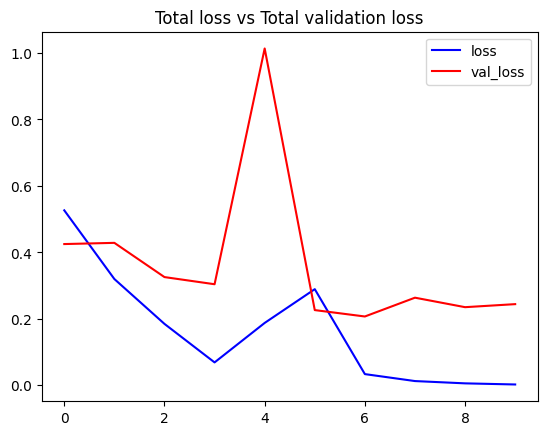

In [56]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total loss vs Total validation loss')

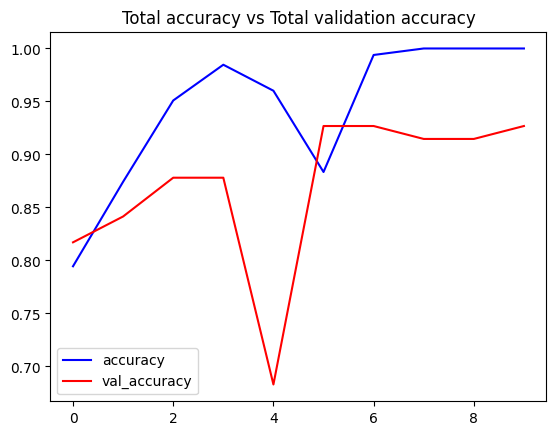

In [57]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total accuracy vs Total validation accuracy')

In [65]:
def create_lrcn_model():

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2, 2)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2, 2)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

In [66]:
lrcn_model = create_lrcn_model()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_21             │ (None, 30, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 30, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 30, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 30, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 30, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 30, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 30, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

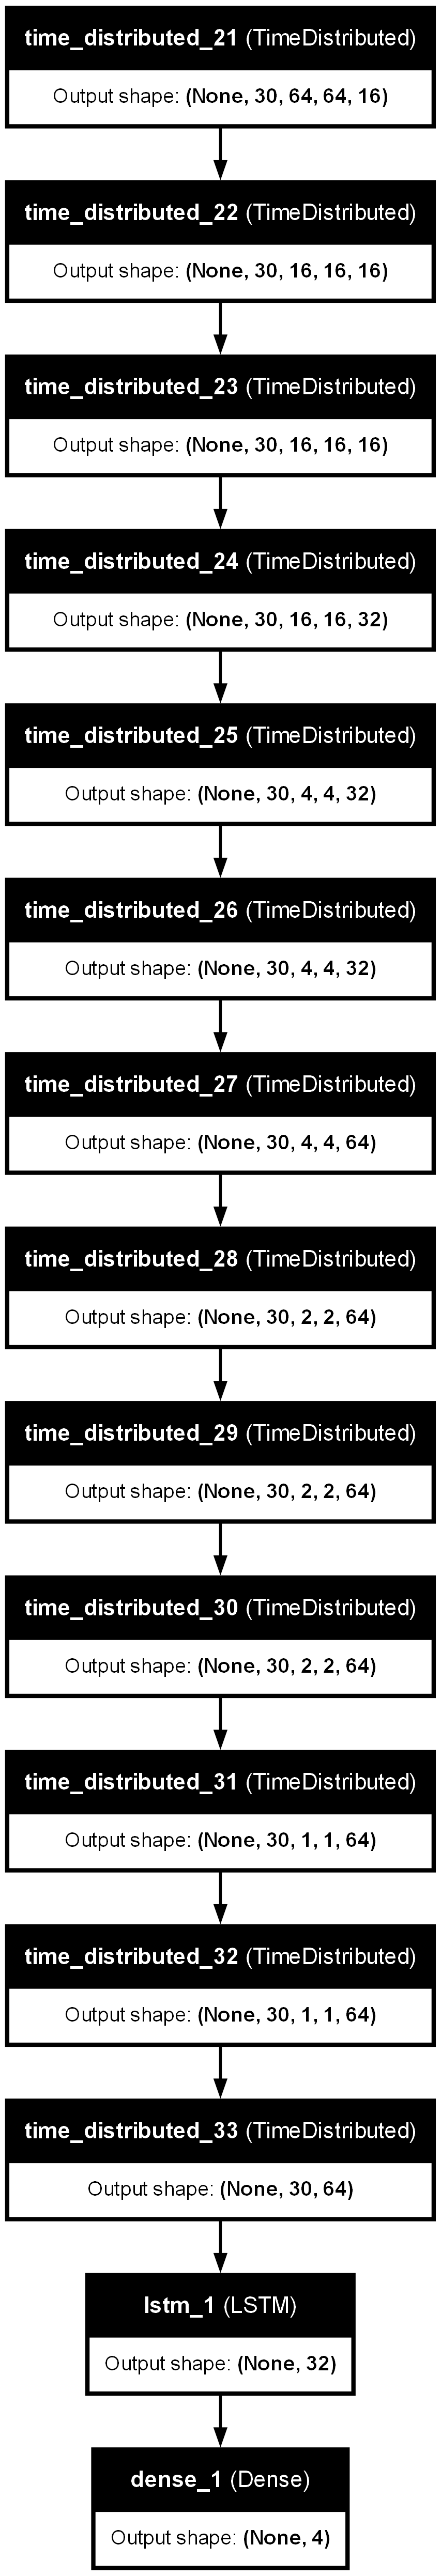

In [67]:
plot_model(lrcn_model, to_file='lrcn_model.png', show_shapes=True, show_layer_names=True)

In [69]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='mln', restore_best_weights=True)

lrcn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
lrcn_model_training_history = lrcn_model.fit(x=features_train, y=labels_train, epochs=10, batch_size=4,
                                                     shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='mln', restore_best_weights=True)



Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.2941 - loss: 1.3990 - val_accuracy: 0.3293 - val_loss: 1.3552
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.3481 - loss: 1.3329 - val_accuracy: 0.5244 - val_loss: 1.1675
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.5144 - loss: 1.1540 - val_accuracy: 0.5610 - val_loss: 0.9490
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.6226 - loss: 0.8660 - val_accuracy: 0.6220 - val_loss: 0.8709
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.6844 - loss: 0.8515 - val_accuracy: 0.7683 - val_loss: 0.5530
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.7366 - loss: 0.6488 - val_accuracy: 0.7439 - val_loss: 0.6596
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.7774 - loss: 0.5493 - val_accuracy: 0.8537 - val_loss: 0.3659
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.8704 - loss: 0.3664 - val_accu

In [70]:
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9329 - loss: 0.2442


In [71]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'lrcn_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
lrcn_model.save(model_file_name)

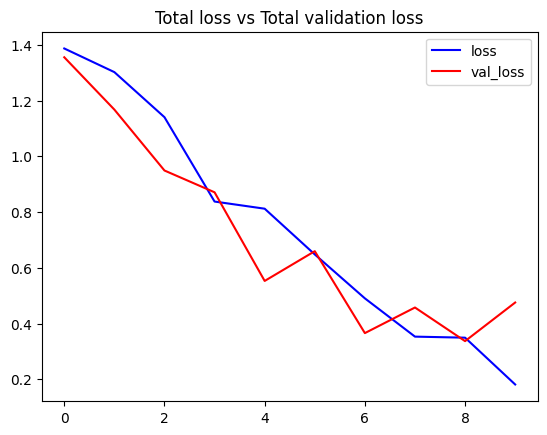

In [72]:
plot_metric(lrcn_model_training_history, 'loss', 'val_loss', 'Total loss vs Total validation loss')

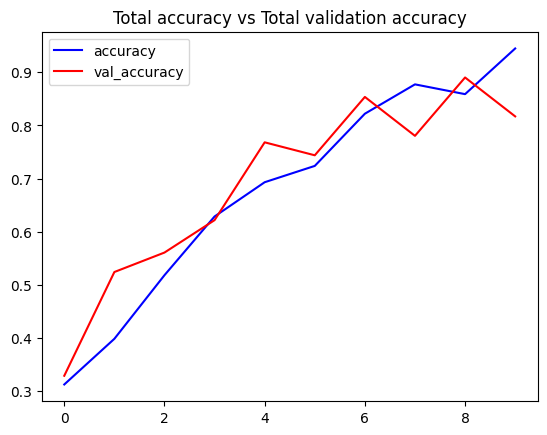

In [73]:
plot_metric(lrcn_model_training_history, 'accuracy', 'val_accuracy', 'Total accuracy vs Total validation accuracy')

In [78]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    
    predict_class_name = ""

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = lrcn_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predict_class_name = CLASSES_LIST[predicted_label]
        
        cv2.putText(frame, predict_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()                              

In [79]:
predict_on_video('data/l8/test_videos/videoplayback.mp4', 'predicted_videoplayback.mp4', 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━